# --------------------------------------------------------------------------------------------
#   Nama : Edward
#   NIM : 2201741971                                                                               
#   Selected Topics in Computational Intelligence I (COMP8038041)
#   Kelas : LTY1                                                                                       
# --------------------------------------------------------------------------------------------

# Particle Swarm Optimization (PSO)

In [1]:
#######################   IMPORT DEPENDENCIES   ################################
import numpy as np
import matplotlib.pyplot as plt

In [2]:
###########################  PARTICLE CLASS  ###################################
class Particle:

    def __init__(self, n=2, vmax=1, X0=None, bound=None):

        '''

        PARAMETERS:
        
        n: TOTAL DIMENSIONS
        
        vmax: MAXIMUM LIMITED VELOCITY OF A PARTICLE

        X0: INITIAL POSITION OF PARTICLE SPECIFIED BY USER

        bound: AXIS BOUND FOR EACH DIMENSION

        ################ EXAMPLE #####################
        
        If X = [x,y,z], n = 3 and if
        bound = [(-5,5),(-1,1),(0,5)]
        Then, x∈(-5,5); y∈(-1,1); z∈(0,5)

        ##############################################

        X: PARTICLE POSITION OF SHAPE (n,1)

        V: PARTICLE VELOCITY OF SHAPE (n,1)

        pbest: PARTICLE'S OWN BEST POSITION OF SHAPE (n,1)
        
        '''

        # IF INITIAL POSITION 'X0' IS NOT SPECIFIED THEN DO RANDOM INITIALIZATION OF 'X'

        if X0 is None:
            self.X = 2*np.random.rand(n,1) - 1
        else:
            self.X = np.array(X0, dtype='float64').reshape(-1,1)
        self.bound = bound
        self.n = n
        self.vmax = vmax
        
        '''

        np.random.rand() ∈ (0,1)
        
        THEREFORE 2*vmax*np.random.rand() ∈ (0,2*vmax)
        
        THUS, V = 2*vmax*np.random.rand() - vmax ∈ (-vmax,vmax)
        
        '''

        self.V = 2*vmax*np.random.rand(n,1) - vmax
        self.clip_X()

        # INITIALIZE 'pbest' WITH A COPY OF 'X' 

        self.pbest = self.X.copy()
        
    def clip_X(self):

        # IF BOUND IS SPECIFIED THEN CLIP 'X' VALUES SO THAT THEY ARE IN THE SPECIFIED RANGE
        
        if self.bound is not None:
            for i in range(self.n):
                xmin, xmax = self.bound[i]
                self.X[i,0] = np.clip(self.X[i,0], xmin, xmax)
    
    def update_velocity(self, w, c1, c2, gbest):

        '''

        PARAMETERS:

        w: INERTIA WEIGHT

        c1: INDIVIDUAL COGNITIVE PARAMETER

        c2: SOCIAL LEARNING PARAMETER

        gbest: GLOBAL BEST POSITION (BEST POSITION IN GROUP) OF SHAPE (n,1)

        ACTION:

        UPDATE THE PARTICLE'S VELOCITY
        
        '''

        self.clip_X()
        self.V = w*self.V # PARTICLE'S PREVIOUS MOTION 
        self.V += c1*np.random.rand()*(self.pbest - self.X) # COGNITIVE VELOCITY 
        self.V += c2*np.random.rand()*(gbest - self.X) # SOCIAL VELOCITY
        self.V = np.clip(self.V, -self.vmax, self.vmax) 
    
    def update_position(self):

        '''
            ACTION:

            UPDATE THE PARTICLE'S POSITION

        '''
        
        self.X += self.V 
        self.clip_X()

In [103]:
########################### TEMP ARRAY FOR PLOTTING #######################################

Fitness_Values_PSO = []

In [111]:
###########################  PSO CLASS  ####################################
class PSO:

    def __init__(self, fitness, P=30, n=2, w=0.72984, c1=2.8, c2=2.05, Tmax=300, vmax=1, X0=None, bound=None,
                update_w=False, update_c1=False, update_c2=False, update_vmax=False, plot=False, min=True, verbose=False):

        '''

        THE SYMBOLS OR NOTATIONS WERE TAKEN FROM [1] AND [2]

        PARAMETERS:

        fitness: A FUNCTION WHICH EVALUATES COST (OR THE FITNESS) VALUE

        P: POPULATION SIZE

        n: TOTAL DIMENSIONS

        w: INERTIA WEIGHT (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_w' VALUE)

        update_w: BOOL VALUE (TRUE WHEN 'w' CHANGES WITH ITERATION AND FALSE IF 'w' IS CONSTANT)

        c1: INDIVIDUAL COGNITIVE PARAMETER (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_c1' VALUE)

        update_c1: BOOL VALUE (TRUE WHEN 'c1' CHANGES WITH ITERATION AND FALSE IF 'c1' IS CONSTANT)

        c2: SOCIAL LEARNING PARAMETER (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_c2' VALUE)

        update_c2: BOOL VALUE (TRUE WHEN 'c2' CHANGES WITH ITERATION AND FALSE IF 'c2' IS CONSTANT)

        Tmax: MAXIMUM ITERATION

        vmax: MAXIMUM LIMITED VELOCITY OF A PARTICLE (CAN BE A CONSTANT OR CHANGES WITH ITERATION BASED ON 'update_vmax' VALUE)

        update_vmax: BOOL VALUE (TRUE WHEN 'vmax' CHANGES WITH ITERATION AND FALSE IF 'vmax' IS CONSTANT)

        X0: INITIAL POSITION OF PARTICLE SPECIFIED BY USER

        bound: AXIS BOUND FOR EACH DIMENSION

        ################ EXAMPLE #####################
        
        If X = [x,y,z], n = 3 and if
        bound = [(-5,5),(-1,1),(0,5)]
        Then, x∈(-5,5); y∈(-1,1); z∈(0,5)

        ##############################################

        plot: BOOL VALUE (TRUE IF PLOT BETWEEN GLOBAL FITNESS (OR COST) VALUE VS ITERATION IS NEEDED ELSE FALSE)

        min: BOOL VALUE (TRUE FOR 'MINIMIZATION PROBLEM' AND FALSE FOR 'MAXIMIZATION PROBLEM')

        verbose: BOOL VALUE (TRUE IF PRINTING IS REQUIRED TO SHOW GLOBAL FITNESS VALUE FOR EACH ITERATION ELSE FALSE)
        
        '''

        self.fitness = fitness
        self.P = P 
        self.n = n 
        self.w = w
        self.c1, self.c2 = c1, c2
        self.Tmax = Tmax
        self.vmax = vmax
        self.X = X0
        self.bound = bound
        self.update_w = update_w 
        self.update_c1 = update_c1
        self.update_c2 = update_c2
        self.update_vmax = update_vmax
        self.plot = plot
        self.min = min
        self.verbose = verbose
        
    def optimum(self, best, particle_x):

        '''

        PARAMETERS:

        best: EITHER LOCAL BEST SOLUTION 'pbest' OR GLOBAL BEST SOLUTION 'gbest'

        particle_x: PARTICLE POSITION

        ACTION:

        COMPARE PARTICLE'S CURRENT POSITION EITHER WITH LOCAL BEST OR GLOBAL BEST POSITIONS
        
            1. IF PROBLEM IS MINIMIZATION (min=TRUE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'

            IS LESS THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS GREATER, THEN IT

            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL OR LOCAL) SOLUTION
            
            2. IF PROBLEM IS MAXIMIZATION (min=FALSE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'

            IS GREATER THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS LESS, THEN IT

            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL OR LOCAL) SOLUTION
        
        '''
        
        if self.min:
            if self.fitness(best) > self.fitness(particle_x):
                best = particle_x.copy()
        else:
            if self.fitness(best) < self.fitness(particle_x):
                best = particle_x.copy()
        return best

    def initialize(self):

        '''

        PARAMETERS:

        population: A LIST OF SIZE (P,) WHICH STORES ALL THE SWARM PARTICLE OBJECT

        gbest: GLOBAL BEST POSITION (BEST POSITION IN GROUP) OF SHAPE (n,1)
        
        ACTION:

        FOR EACH PARTICLE 'i' IN SWARM POPULATION OF SIZE 'P'

            1. IT INITIALIZE POSITION 'X' AND VELOCITY 'V' OF PARTICLE 'i' AND STORES IT IN 'population' LIST

            2. INITIALIZE 'gbest' WITH COPY OF 'ith' PARTICLE'S POSITION 'X' HAVING BEST FITNESS
        
        '''
        
        self.population = []
        for i in range(self.P):
            self.population.append(Particle(n=self.n, vmax=self.vmax, X0=self.X, bound=self.bound))
            if i==0:
                self.gbest = self.population[0].X.copy()
            else:
                self.gbest = self.optimum(self.gbest, self.population[i].X)

    def update_coeff(self):
        
        '''

        ACCORDING TO THE PAPER BY M. CLERC AND J. KENNEDY [3], TO DEFINE A STANDARD FOR PARTICLE SWARM OPTIMIZATION,
        
        THE BEST STATIC PARAMETERS ARE w=0.72984 AND c1 + c2 >= 4. MORE EXACTLY c1 = 2.05 AND c2 = 2.05

        BUT ACCORDING TO [2] SOME OTHER RESEARCHERS THOUGHT THAT c1 DID NOT EQUAL c2 , AND REACHED A CONCLUSION

        c1 = 2.8 FROM EXPERIMENTS.


        BASED ON THESE IDEAS AND INSPIRED BY THE PAPER BY G. SERMPINIS [5], 
    
        [6] SUGGEST THE UPDATION OF THE COEFFICIENTS (c1 AND c2) AS CODED HERE.
        

        ADDITIONALLY, THE LINEAR DECAY OF THE PARAMETER 'w' WAS INITIALLY PROPOSED BY 

        YUHUI AND RUSS Y. H. SHI AND R. C. EBERHART [4].


        CONCEPT OF UPDATING MAXIMUM VECOLITY IS ALSO AVAILABLE IN [2]
    
        '''

        if self.update_w:
            self.w = 0.9 - 0.5*(self.t/self.Tmax)
        if self.update_c1:
            self.c1 = 3.5 - 3*(self.t/self.Tmax)
        if self.update_c2:
            self.c2 = 0.5 + 3*(self.t/self.Tmax)
        if self.update_vmax:
            self.vmax = 1.5*np.exp(1-((self.t/self.Tmax)))

    def move(self):

        '''

        PARAMETERS:

        t: ITERATION NUMBER

        fitness_time: LIST STORING FITNESS (OR COST) VALUE FOR EACH ITERATION

        time: LIST STORING ITERATION NUMBER ([0,1,2,...])

        ACTION:

        AS THE NAME SUGGESTS, THIS FUNCTION MOVES THE PARTICLES BY UPDATING THEIR

        POSITION AND VELOCITY. ALSO BASED ON THE TYPE OF PROBLEM (MAXIMIZATION OR

        MINIMIZATION), IT CALLS THE 'optimum' FUNCTION AND EVALUATE THE 'gbest'

        AND 'pbest' PARAMETERS USING FITNESS VALUE. IT ALSO UPDATE THE COEFFICIENTS.
        

        NOTE: THIS FUNCTION PRINTS THE GLOBAL FITNESS VALUE FOR EACH ITERATION

        IF THE VERBOSE IS TRUE

        FOLLOW [1] WHERE THE PSO ALGORITHM PSEUDO CODE IS PRESENT IN 'FIGURE-1'
        
        '''
        
        self.t = 0
        self.fitness_time, self.time = [], []
        while self.t <= self.Tmax:
            self.update_coeff()
            for particle in self.population:
                particle.update_velocity(self.w, self.c1, self.c2, self.gbest)
                particle.update_position()
                particle.pbest = self.optimum(particle.pbest, particle.X)
                self.gbest = self.optimum(self.gbest, particle.X)
            self.fitness_time.append(self.fitness(self.gbest))
            self.time.append(self.t)
            if self.verbose:
                print('Iteration:  ',self.t,'| best global fitness (cost):',round(self.fitness(self.gbest),7))
                Fitness_Values_PSO.append(round(self.fitness(self.gbest),7))
            self.t += 1

    def execute(self):

        '''

        A KIND OF MAIN FUNCTION 

        PRINTS THE FINAL SOLUTION

        '''
        self.initialize()
        self.move()
        print('\nOPTIMUM SOLUTION\n  >', np.round(self.gbest.reshape(-1),7).tolist())
        print('\nOPTIMUM FITNESS\n  >', np.round(self.fitness(self.gbest),7))
        print()
        if self.plot:
            self.Fplot()
        
    def Fplot(self):

        # PLOTS GLOBAL FITNESS (OR COST) VALUE VS ITERATION GRAPH
        plt.plot(self.time, self.fitness_time)
        plt.title('Fitness value vs Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness value')
        plt.show()

In [4]:
######################## Rosenbrock Function ######################################

def Rosenbrock_Function(X):

    '''

    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)

    EXAMPLE PRESENT IN [7] FOR 2-DIMENSIONAL VECTORS (X = (x,y))

    #################################################################################

    ROSENBROCK'S FUNCTION

    MINIMIZE f(x) = (1 - x)^2 + 100(y - x^2)^2
    
    OPTIMUM SOLUTION IS x* = 1 AND y* = 1

    REPLACE 'f' BELOW WITH THIS TO TEST

    f = (1 - x)**2 + 100*(y - x**2)**2

    '''

    x, y = X[0][0], X[1][0]
    f = (1 - x)**2 + 100 * (y - x**2)**2
    return f

Iteration:   0 | best global fitness (cost): 0.5747892
Iteration:   1 | best global fitness (cost): 0.2851783
Iteration:   2 | best global fitness (cost): 0.2851783
Iteration:   3 | best global fitness (cost): 0.2851783
Iteration:   4 | best global fitness (cost): 0.1994104
Iteration:   5 | best global fitness (cost): 0.0662312
Iteration:   6 | best global fitness (cost): 0.0662312
Iteration:   7 | best global fitness (cost): 0.0662312
Iteration:   8 | best global fitness (cost): 0.0662312
Iteration:   9 | best global fitness (cost): 0.0662312
Iteration:   10 | best global fitness (cost): 0.0662312
Iteration:   11 | best global fitness (cost): 0.0030739
Iteration:   12 | best global fitness (cost): 0.0030739
Iteration:   13 | best global fitness (cost): 0.0030739
Iteration:   14 | best global fitness (cost): 0.0030739
Iteration:   15 | best global fitness (cost): 0.0030739
Iteration:   16 | best global fitness (cost): 0.0030739
Iteration:   17 | best global fitness (cost): 0.0030739
It

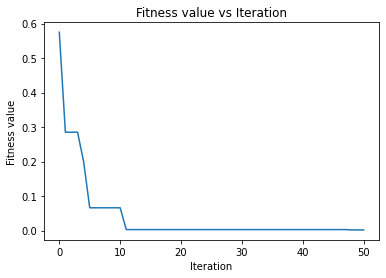

In [6]:
'''
    A bool variable min=True (default value) for MINIMIZATION PROBLEM and min=False for MAXIMIZATION PROBLEM

    Print the fitness value for each iteration, then set verbose=True

    #################################################################################

    Plotting Result

    To plot the fitness value for each iteration, then set plot=True (here Tmax=50 is the maximum iteration)

    '''

PSO(fitness=Rosenbrock_Function, min=True, Tmax=50, verbose=True, plot=True).execute()

In [9]:
'''
    To use the advanced features as Hyper Parameters Tuning (say I want to update the weight inertia parameter w),

    simply use update_w=True and thats it. Similarly I can use update_c1=True (to update individual cognitive parameter c1),

    update_c2=True (to update social learning parameter c2), and update_vmax=True (to update maximum limited velocity of the

    particle vmax)

    To plot the fitness value for each iteration, then set plot=True (here Tmax=50 is the maximum iteration)

    '''

'\n    To use the advanced features as Hyper Parameters Tuning (say I want to update the weight inertia parameter w),\n\n    simply use update_w=True and thats it. Similarly I can use update_c1=True (to update individual cognitive parameter c1),\n\n    update_c2=True (to update social learning parameter c2), and update_vmax=True (to update maximum limited velocity of the\n\n    particle vmax)\n\n    To plot the fitness value for each iteration, then set plot=True (here Tmax=50 is the maximum iteration)\n\n    '

### First, just update weight and individual cognitive

Iteration:   0 | best global fitness (cost): 0.3956132
Iteration:   1 | best global fitness (cost): 0.2412084
Iteration:   2 | best global fitness (cost): 0.2412084
Iteration:   3 | best global fitness (cost): 0.2412084
Iteration:   4 | best global fitness (cost): 0.2412084
Iteration:   5 | best global fitness (cost): 0.2408703
Iteration:   6 | best global fitness (cost): 0.2408703
Iteration:   7 | best global fitness (cost): 0.1409311
Iteration:   8 | best global fitness (cost): 0.1409311
Iteration:   9 | best global fitness (cost): 0.1409311
Iteration:   10 | best global fitness (cost): 0.1409311
Iteration:   11 | best global fitness (cost): 0.1132017
Iteration:   12 | best global fitness (cost): 0.1132017
Iteration:   13 | best global fitness (cost): 0.0268138
Iteration:   14 | best global fitness (cost): 0.0268138
Iteration:   15 | best global fitness (cost): 0.0268138
Iteration:   16 | best global fitness (cost): 0.0268138
Iteration:   17 | best global fitness (cost): 0.0247529
It

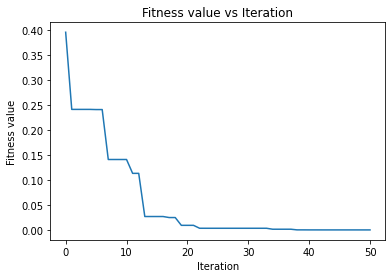

In [10]:
PSO(fitness=Rosenbrock_Function, min=True, update_w=True, update_c1=True, Tmax=50, verbose=True, plot=True).execute()

### Second, update weight and individual cognitive with social learning

Iteration:   0 | best global fitness (cost): 0.5021168
Iteration:   1 | best global fitness (cost): 0.4790376
Iteration:   2 | best global fitness (cost): 0.4790376
Iteration:   3 | best global fitness (cost): 0.4790376
Iteration:   4 | best global fitness (cost): 0.4790376
Iteration:   5 | best global fitness (cost): 0.4647664
Iteration:   6 | best global fitness (cost): 0.2642326
Iteration:   7 | best global fitness (cost): 0.197883
Iteration:   8 | best global fitness (cost): 0.196397
Iteration:   9 | best global fitness (cost): 0.196397
Iteration:   10 | best global fitness (cost): 0.1823326
Iteration:   11 | best global fitness (cost): 0.0866283
Iteration:   12 | best global fitness (cost): 0.016986
Iteration:   13 | best global fitness (cost): 0.016986
Iteration:   14 | best global fitness (cost): 0.016986
Iteration:   15 | best global fitness (cost): 0.0076737
Iteration:   16 | best global fitness (cost): 0.0076737
Iteration:   17 | best global fitness (cost): 0.0076737
Iteratio

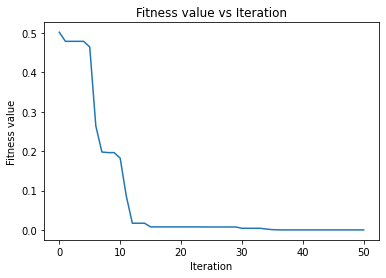

In [12]:
PSO(fitness=Rosenbrock_Function, min=True, update_w=True, update_c1=True, update_c2=True, Tmax=50, verbose=True, plot=True).execute()

### Third, update weight , individual cognitive, social learning with maximum velocity

Iteration:   0 | best global fitness (cost): 0.4682917
Iteration:   1 | best global fitness (cost): 0.4682917
Iteration:   2 | best global fitness (cost): 0.4682917
Iteration:   3 | best global fitness (cost): 0.4682917
Iteration:   4 | best global fitness (cost): 0.2955063
Iteration:   5 | best global fitness (cost): 0.2898165
Iteration:   6 | best global fitness (cost): 0.2898165
Iteration:   7 | best global fitness (cost): 0.2843437
Iteration:   8 | best global fitness (cost): 0.2145481
Iteration:   9 | best global fitness (cost): 0.1922619
Iteration:   10 | best global fitness (cost): 0.1196471
Iteration:   11 | best global fitness (cost): 0.1196471
Iteration:   12 | best global fitness (cost): 0.1196471
Iteration:   13 | best global fitness (cost): 0.1196471
Iteration:   14 | best global fitness (cost): 0.0770347
Iteration:   15 | best global fitness (cost): 0.0770347
Iteration:   16 | best global fitness (cost): 0.0702029
Iteration:   17 | best global fitness (cost): 0.0702029
It

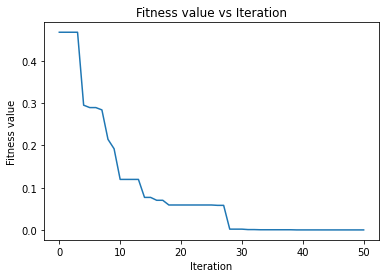

In [112]:
PSO(fitness=Rosenbrock_Function, min=True, update_w=True, update_c1=True, update_c2=True, update_vmax=True, Tmax=50, verbose=True, plot=True).execute()

## Particle Swarm Optimization (PSO) References:
### [1] Almeida, Bruno & Coppo leite, Victor. (2019). Particle swarm optimization: a powerful technique for solving engineering problems. 10.5772/intechopen.89633.
### [2] He, Yan & Ma, Wei & Zhang, Ji. (2016). The parameters selection of pso algorithm influencing on performance of fault diagnosis. matec web of conferences. 63. 02019. 10.1051/matecconf/20166302019.
### [3] Clerc, M., and J. Kennedy. The particle swarm — explosion, stability, and convergence in a multidimensional complex space. ieee transactions on evolutionary computation 6, no. 1 (february 2002): 58–73.
### [4] Y. H. Shi and R. C. Eberhart, “A modified particle swarm optimizer,” in proceedings of the ieee international conferences on evolutionary computation, pp. 69–73, anchorage, alaska, usa, may 1998.
### [5] G. Sermpinis, K. Theofilatos, A. Karathanasopoulos, E. F. Georgopoulos, & C. Dunis, Forecasting foreign exchange rates with adaptive neural networks using radial-basis functions and particle swarm optimization, european journal of operational research.
### [6] Particle swarm optimization (pso) visually explained (https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14)
### [7] Rajib Kumar Bhattacharjya, Introduction to Particle Swarm Optimization (http://www.iitg.ac.in/rkbc/ce602/ce602/particle%20swarm%20algorithms.pdf)

In [113]:
len(Fitness_Values_PSO)

51

# Artificial Bee Colony (ABC)

In [16]:
#######################   IMPORT DEPENDENCIES   ################################
import numpy as np
import random as rand
import time
import matplotlib.pyplot as plt

In [99]:
########################### TEMP ARRAY FOR PLOTTING #######################################
Fitness_Values_ABC = []

In [90]:
###########################  ARTIFICIAL BEE COLONY CLASS #######################################
class ArtificialBeeColony:

    def __init__(self, D, Lb, Ub, n, generation, ans, func):
        self.D = D
        self.Lb = Lb
        self.Ub = Ub
        self.n = n
        self.generation = generation
        self.ans = ans
        self.func = func
        self.bestFunc = 0
        self.bestFoodSourceArray = np.zeros(D)
        self.foodSourceArray = np.ones((n,D))
        self.tmpFoodSourceArray = np.ones(D)
        self.funcArray = np.ones(n)
        self.fitnessArray = np.ones(n)
        self.trialArray = np.zeros(n)
        self.pArray = np.zeros(n)
        
    def fitness(self,X):
        """
            Evaluates the fitness of a solution vector.
            The fitness is a measure of the quality of a solution.
        """
        if(X >= 0):
            return 1/(1 + X)
        else:
            return 1 + abs(X)

    def generateNew(self,X,Xp):
        """
            Checks that a solution vector is contained within the
            pre-determined lower and upper bounds of the problem.
        """
        
        Xnew = X + rand.uniform(-1,1)*(X - Xp)
        if(Xnew < self.Lb): return self.Lb
        elif(Xnew > self.Ub): return self.Ub
        else: return Xnew

    def updateSolution(self,index):
        """
            Computes the relative chance that a given solution vector is
            chosen by an onlooker bee after the Waggle dance ceremony when
            employed bees are back within the hive.
        """
        randVariableToChange = rand.randint(0,self.D-1)
        randPartner = index
        while(randPartner == index):
            randPartner = rand.randint(0,self.n-1)

        for j in range(self.D):
            self.tmpFoodSourceArray[j] = self.foodSourceArray[index][j]
        self.tmpFoodSourceArray[randVariableToChange] = self.generateNew(self.foodSourceArray[index][randVariableToChange], self.foodSourceArray[randPartner][randVariableToChange])
        
        if(self.ans == 0): 
            oriVal = self.funcArray[index]
            newVal = self.func(self.tmpFoodSourceArray,self.D)
        elif(self.ans == 1):
            oriVal = self.fitnessArray[index]
            newVal = self.fitness(self.func(self.tmpFoodSourceArray,self.D))

        if(newVal < oriVal):
            self.foodSourceArray[index][randVariableToChange] = self.tmpFoodSourceArray[randVariableToChange]
            self.funcArray[index] = self.func(self.tmpFoodSourceArray,self.D)
            self.fitnessArray[index] = self.fitness(self.func(self.tmpFoodSourceArray,self.D))
            self.trialArray[index] = 0
        else:
            self.trialArray[index] = self.trialArray[index] + 1
            
    def printLocalBestSolution_MAX(self):
        localBest = int(np.where(self.funcArray == self.funcArray.max())[0])
        print("Local Best Food Source:", self.foodSourceArray[localBest])
        print("local Best F(x) =",self.funcArray.max())
        Fitness_Values_ABC.append(self.funcArray.max())
        if(self.funcArray.max() > self.bestFunc):
            for i in range(self.D):
                self.bestFoodSourceArray[i] = self.foodSourceArray[localBest][i]
            self.bestFunc = self.funcArray.max()
            
    def printLocalBestSolution_MIN(self):
        localBest = int(np.where(self.funcArray == self.funcArray.min())[0])
        print("Local Best Food Source:", self.foodSourceArray[localBest])
        print("local Best F(x) =",self.funcArray.min())
        Fitness_Values_ABC.append(self.funcArray.min())
        if(self.funcArray.min() < self.bestFunc):
            for i in range(self.D):
                self.bestFoodSourceArray[i] = self.foodSourceArray[localBest][i]
            self.bestFunc = self.funcArray.min()
        
    def printCurrentSolution(self):
        print("==================================")
        print("foodSourceArray\n", self.foodSourceArray)
        print("funcArray\n", self.funcArray)
        print("fitnessArray\n", self.fitnessArray)
        print("trialArray\n", self.trialArray)
        print("==================================")
    
    def init(self):
        if(self.ans == 0): self.bestFunc = float("inf")
        elif(self.ans == 1): self.bestFunc = -float("inf")
        """
            Mutates a given solution vector - i.e. for continuous
            real-values.
        """
        for i in range(self.n):
            for j in range(self.D):
                self.foodSourceArray[i][j] = rand.uniform(self.Lb, self.Ub)
            self.funcArray[i] = self.func(self.foodSourceArray[i,:],self.D)
            self.fitnessArray[i] = self.fitness(self.funcArray[i])
    
    def Fplot(self):

        # PLOTS GLOBAL FITNESS (OR COST) VALUE VS ITERATION GRAPH
        
        Fitness_Values_ABC = self.fitnessArray
        plt.plot(self.fitnessArray)
        plt.title('Fitness value vs Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness value')
        plt.show()
    
    def doRun(self):
        start = time.time()
        self.init()
            
        for gen in range(self.generation):
            print("Generation:", gen+1)

            #Employed Bee Phase
            """
                EMPLOYED BEE PHASE.
                ---------------------------
                During this phase, new candidate solutions are produced for
                each employed bee by cross-over and mutation of the employees.
                If the modified vector of the mutant bee solution is better than
                that of the original bee, the new vector is assigned to the bee.
            """
            for i in range(self.n):
                self.updateSolution(i)

            #Onlooker Bee Phase
            """
                ONLOOKER BEE PHASE.
                -----------------------
                Define as many onlooker bees as there are employed bees in
                the hive since onlooker bees will attempt to locally improve the
                solution path of the employed bee they have decided to follow
                after the waggle dance phase.
                If they improve it, they will communicate their findings to the bee
                they initially watched "waggle dancing".
            """
            for i in range(self.n):
                self.pArray[i] = self.fitnessArray[i]/self.fitnessArray.sum()
            for i in range(self.n):
                if(rand.random() < self.pArray[i]):
                    self.updateSolution(i)
            
            if(self.ans == 0): self.printLocalBestSolution_MIN()
            elif(self.ans == 1): self.printLocalBestSolution_MAX()
            
            #Scout Bee Phase
            """
                SCOUT BEE PHASE.
                -----------------------
                Identifies bees whose abandonment counts exceed preset trials limit,
                abandons it and creates a new random bee to explore new random area
                of the domain space.
                In real life, after the depletion of a food nectar source, a bee moves
                on to other food sources.
                By this means, the employed bee which cannot improve their solution
                until the abandonment counter reaches the limit of trials becomes a
                scout bee. Therefore, scout bees in ABC algorithm prevent stagnation
                of employed bee population.
                Intuitively, this method provides an easy means to overcome any local
                optima within which a bee may have been trapped.
            """
            limit = 1
            for i in range(self.n):
                if(self.trialArray[i] > limit):
                    for j in range(self.D):
                        self.foodSourceArray[i][j] = rand.uniform(self.Lb, self.Ub)
                    self.funcArray[i] = self.func(self.foodSourceArray[i,:],self.D)
                    self.fitnessArray[i] = self.fitness(self.funcArray[i])
                    self.trialArray[i] = 0
        end = time.time()
        print("============================================")
        print("Time Consume：%f " % (end - start))
        print("Best Food Source:", self.bestFoodSourceArray)
        print("Best F(x) =", self.bestFunc)
        self.Fplot()

In [91]:
def Rosenbrock_Function_ABC(X,D):
    x = X[0]
    y = X[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

Generation: 1
Local Best Food Source: [1.68438533 2.77244722]
local Best F(x) = 0.8870794330971348
Generation: 2
Local Best Food Source: [1.68438533 2.77244722]
local Best F(x) = 0.8870794330971348
Generation: 3
Local Best Food Source: [0.77643246 0.48433495]
local Best F(x) = 1.4545017419263297
Generation: 4
Local Best Food Source: [0.68022687 0.48433495]
local Best F(x) = 0.14902479154820966
Generation: 5
Local Best Food Source: [0.68022687 0.48433495]
local Best F(x) = 0.14902479154820966
Generation: 6
Local Best Food Source: [1.01556627 0.96548137]
local Best F(x) = 0.4344372476404862
Generation: 7
Local Best Food Source: [1.01556627 0.96548137]
local Best F(x) = 0.4344372476404862
Generation: 8
Local Best Food Source: [0.20579785 0.03185627]
local Best F(x) = 0.6417746689275287
Generation: 9
Local Best Food Source: [0.20579785 0.03185627]
local Best F(x) = 0.6417746689275287
Generation: 10
Local Best Food Source: [1.80944718 3.14299686]
local Best F(x) = 2.373984860008815
Generati

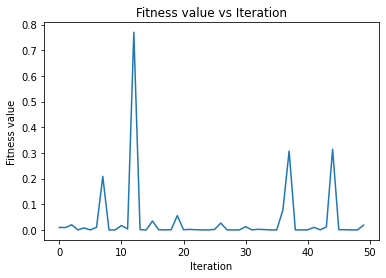

In [100]:
# ArtificialBeeColony(D, Lb, Ub, n, generation, ans[min=0/max=1], func)
abc = ArtificialBeeColony(2, -5, 5, 50, 50, 0, Rosenbrock_Function_ABC)
abc.doRun()

### Artificial Bee Colony (ABC) References:
## Karaboga, D. (2005), ""An Idea Based on Honey Bee Swarm for Numerical Optimization," Technical Report-TR06, Department of Computer Engineering, Engineering Faculty, Erciyes University, Turkey.
## Deb, K. (2000), "An efficient constraint handling method for genetic algorithms," Computer Methods in Applied Mechanics and Engineering, 186(2- 4):311–338, Elsevier, Netherlands.
## http://www.sciencedirect.com/science/article/pii/S1568494609002798
## http://mf.erciyes.edu.tr/abc/index.htm
## http://www.mathworks.com/matlabcentral/fileexchange/52966-artificial-bee-colony--abc--in-matlab/content/YPEA114%20Artificial%20Bee%20Colony/Artificial%20Bee%20Colony/abc.m
## http://www.scholarpedia.org/article/Artificial_bee_colony_algorithm

## Result Difference

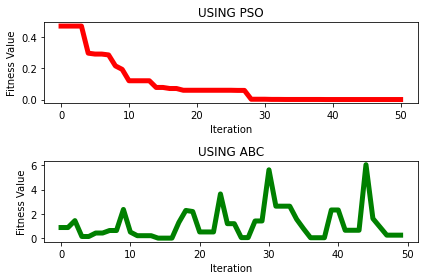

In [122]:
# using subplot function and creating plot one
# row 2, column 1, count 1
plt.subplot(2, 1, 1)
plt.plot(Fitness_Values_PSO, 'r', linewidth=5)
plt.title('USING PSO')
plt.xlabel('Iteration')
plt.ylabel('Fitness Value')
 
# using subplot function and creating plot two
# row 2, column 1, count 2
plt.subplot(2, 1, 2)
plt.plot(Fitness_Values_ABC, 'g', linewidth=5)
plt.title('USING ABC')
plt.xlabel('Iteration')
plt.ylabel('Fitness Value')
 
# space between the plots
plt.tight_layout()
 
# show plot
plt.show()

### Final Analysis is PSO is more Less Cost Value than ABC.`